In [1]:
import numpy as np 
import pandas as pd 
from collections import Counter
import os
print(os.listdir("../input"))


['IDC_regular_ps50_idx5']


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

import torch
torch.cuda.manual_seed_all(7)


In [4]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=20., max_zoom=0.05)
len(tfms)

2

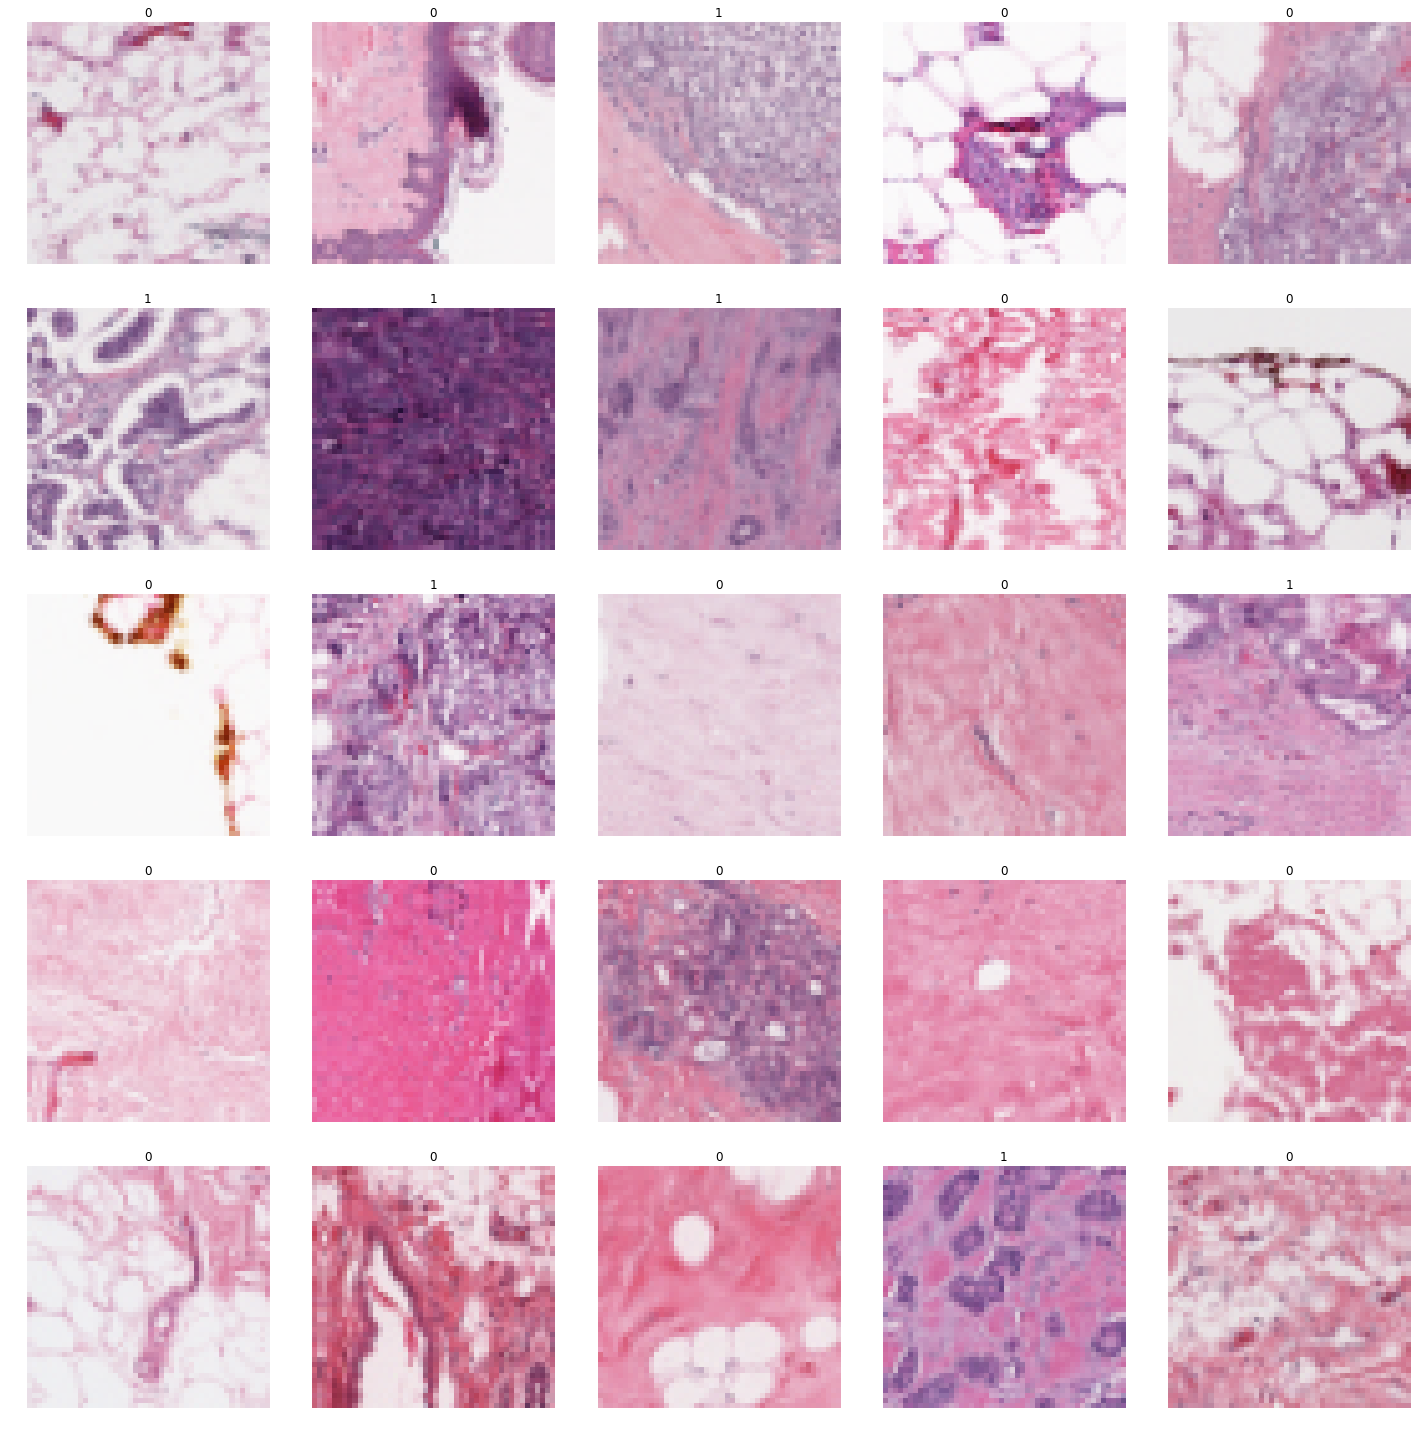

In [5]:
path = '../input/IDC_regular_ps50_idx5/'
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.2,
                                  size=48, bs=128).normalize(imagenet_stats)

data.show_batch()

0 indicates `no IDC` (no breast cancer) while 1 indicates `IDC`  (breast cancer) 

IDC -> Invasive Ductal Carcinoma

## Distribution of the classes in the training and validation splits

In [ ]:
train_counts = Counter(data.train_ds.y)
train_counts.most_common()

In [ ]:
valid_counts = Counter(data.valid_ds.y)
valid_counts.most_common()

In [ ]:
data.label_list

## Looking at a few samples 

In [ ]:
print(data.train_ds[0]);
show_image(data.train_ds[0][0], figsize=(3,3))

In [ ]:
print(data.train_ds[5]);
show_image(data.train_ds[5][0],)

In [ ]:
print(data.train_ds[45]);
show_image(data.train_ds[45][0])

In [ ]:
print(data.valid_ds[45]);
show_image(data.valid_ds[45][0])

In [ ]:
print(data.valid_ds[53]);
show_image(data.valid_ds[53][0])

In [ ]:
print(data.valid_ds[105]);
show_image(data.valid_ds[105][0])

In [ ]:
print(data.valid_ds[598]);
show_image(data.valid_ds[598][0])

In [ ]:
print(data.valid_ds[928]);
show_image(data.valid_ds[928][0])

In [7]:
from torch import nn

weights = [0.4, 1]
class_weights=torch.FloatTensor(weights).cuda()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


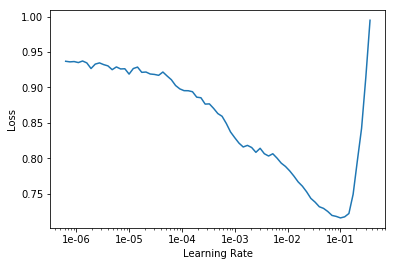

In [8]:
# Begin the training
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], model_dir='/tmp/models').to_fp16()
learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)
learn.lr_find()
learn.recorder.plot()


epoch,train_loss,valid_loss,accuracy,time
0,0.575067,0.442690,0.802158,09:42
1,0.489450,0.393268,0.841309,07:01
2,0.456616,0.373968,0.847020,06:56
3,0.437028,0.367545,0.846894,06:55
4,0.431461,0.367633,0.851200,06:55


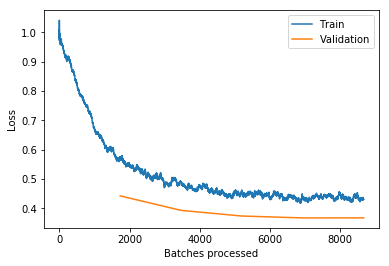

In [9]:
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-05));
learn.recorder.plot_losses()

In [10]:
del learn

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], model_dir='/tmp/models').to_fp16()
learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)

epoch,train_loss,valid_loss,accuracy,time
0,0.430072,0.368791,0.836192,06:59
1,0.353916,0.326488,0.860605,06:58
2,0.329104,0.308426,0.866064,06:57
3,0.325490,0.301255,0.871234,06:58
4,0.320420,0.299954,0.873216,06:53


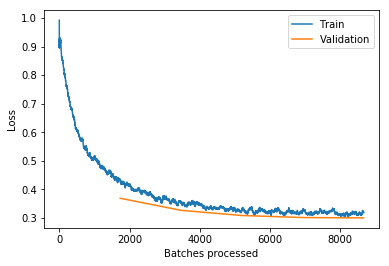

In [13]:
learn.fit_one_cycle(5, max_lr=slice(1e-03, 1e-04));
learn.recorder.plot_losses()

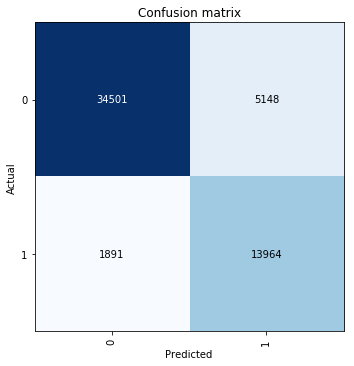

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))

In [16]:
from sklearn.metrics import classification_report

def return_classification_report(learn):
    
    ground_truth = []
    pred_labels = []

    for i in range(len(learn.data.valid_ds)):
        temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
        temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
        pred_labels.append(temp_pred)
        ground_truth.append(temp_truth)

    assert len(pred_labels) == len(ground_truth)
    
    return classification_report(ground_truth, pred_labels, target_names=data.classes)

In [17]:
print(return_classification_report(learn))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     39649
           1       0.73      0.88      0.80     15855

   micro avg       0.87      0.87      0.87     55504
   macro avg       0.84      0.88      0.85     55504
weighted avg       0.89      0.87      0.88     55504



In [18]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.318742,0.297490,0.865235,07:26
1,0.278817,0.272980,0.886783,07:24


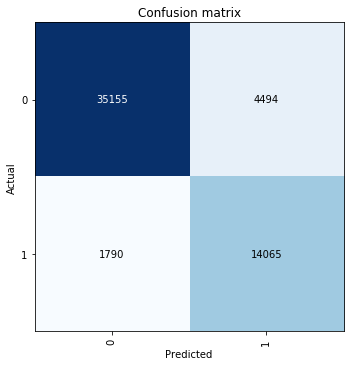

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))

In [20]:
print(return_classification_report(learn))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     39649
           1       0.76      0.89      0.82     15855

   micro avg       0.89      0.89      0.89     55504
   macro avg       0.85      0.89      0.87     55504
weighted avg       0.90      0.89      0.89     55504

